In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import wandb
import pandas as pd

In [8]:
df = pd.read_parquet('0000.parquet', engine='pyarrow')

22500     0.118612
25000     0.102149
27500     0.096981
30000     0.093290
32500     0.091967
            ...   
190000    0.081342
192500    0.081363
195000    0.082148
197500    0.082821
200000    0.083805
Name: val_loss, Length: 72, dtype: float64


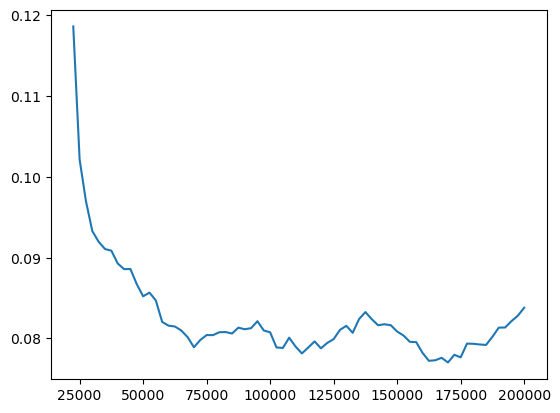

In [28]:
d = df[df["val_loss"].notna()]["val_loss"].rolling(10).mean()
d = d.dropna()
print(d)
x = d.index
y = d.values
plt.plot(x, y)

In [2]:
def get_vals_for_metric(metric, files):
  xs = []
  vals = []
  for f in sorted(files, key=lambda x: int(x.split("/")[-2].split("-")[1])):
    xs.append(int(f.split("/")[-2].split("-")[1]))
    results = json.load(open(f))
    vals.append(results["best_edits"][metric])
  return xs, vals

def get_metrics_for_model(model_name):
  path = f"/home/anton/github/autoseg/src/autoseg/artifacts/{model_name.replace(' ', '_')}/results"
  files = glob.glob(path + "/step-*/result.json")
  for f in files:
    if "step-0" in f:
      files.remove(f)
  print(files)

  xs, merges = get_vals_for_metric("total_merges_needed_to_fix_splits", files)
  _, splits = get_vals_for_metric("total_splits_needed_to_fix_merges", files)
  skel_mods = np.array(merges) + np.array(splits)
  xs = np.array(xs)

  voi_sum = np.array(get_vals_for_metric("voi_sum", files)[1])
  nvi_sum = np.array(get_vals_for_metric("nvi_sum", files)[1])
  return {
    "checkpoints": xs,
    "merges": merges,
    "splits": splits,
    "skel_mods": skel_mods,
    "voi_sum": voi_sum,
    "nvi_sum": nvi_sum
  }

In [64]:
def compare_models(models, metric, scatter=False):
  for model in models:
    avg_metrics = 0
    std = None
    if isinstance(model, list):
      selected_metrics = []
      for model2 in model:
        metrics = get_metrics_for_model(model2)
        selected_metrics.append(metrics[metric])
        if scatter:
          plt.scatter(metrics["checkpoints"], metrics[metric], label=model2)

      selected_metrics = np.array(selected_metrics)
      avg_metrics = np.mean(selected_metrics, axis=0)
      std = np.std(selected_metrics, axis=0)
      checkpoints = metrics["checkpoints"]
      label = model2
      plt.plot(checkpoints, avg_metrics, label=label)
      if std is not None:
        plt.fill_between(checkpoints, avg_metrics - std, avg_metrics + std, alpha=0.3)
      label += " avg"

      best = np.argmin(avg_metrics)
      print(f"Best {metric} for {model2} at checkpoint {checkpoints[best]} with value {avg_metrics[best]} +- {std[best]}")

    else:
      metrics = get_metrics_for_model(model)
      avg_metrics = metrics[metric]
      plt.plot(metrics["checkpoints"], avg_metrics, label=model)
      checkpoints = metrics["checkpoints"]
      label = model

    #plt.plot(metrics["checkpoints"], avg_metrics, label=label)
  plt.title(metric)
  plt.legend()
  plt.show()

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-100000/result.json']
['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_2/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_ru

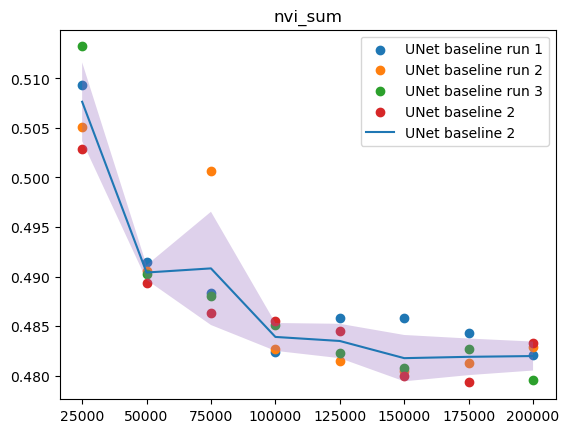

In [65]:
#compare_models(["UNet baseline 2", "UNet LSD 2", "UNet baseline schedule free 2", "UNet LSD GELU LayerNorm"], "voi_sum")
#compare_models(["UNet baseline 2", "UNet LSD 2"], "skel_mods")
#compare_models([["UNet baseline run 1", "UNet baseline run 2", "UNet baseline run 3", "UNet baseline 2"], ["UNet LSD 2 run 1", "UNet LSD 2 run 2", "UNet LSD 2 run 3"]], "skel_mods")
compare_models([["UNet baseline run 1", "UNet baseline run 2", "UNet baseline run 3", "UNet baseline 2"]], "nvi_sum", scatter=True)
#compare_models([["UNet LSD 2 run 1", "UNet LSD 2 run 2", "UNet LSD 2 run 3", "UNet LSD 2"]], "skel_mods")
#compare_models(["UNet baseline run 1", "UNet baseline run 2", "UNet baseline run 3", ["UNet baseline run 1", "UNet baseline run 2", "UNet baseline run 3"]], "skel_mods")

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-100000/result.json']
['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_2/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_2/results/step-200000/result

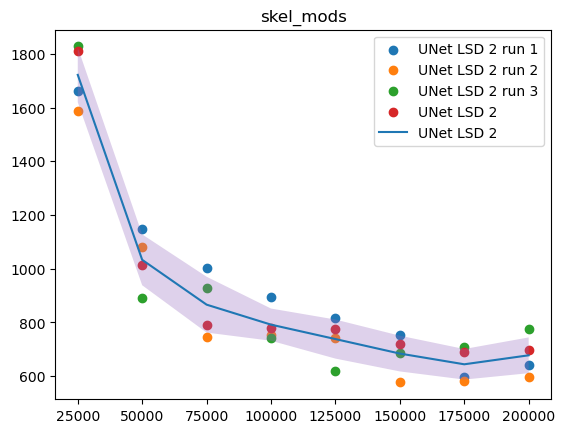

In [56]:
compare_models([["UNet LSD 2 run 1", "UNet LSD 2 run 2", "UNet LSD 2 run 3", "UNet LSD 2"]], "skel_mods")

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-100000/result.json']
['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_2/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_ru

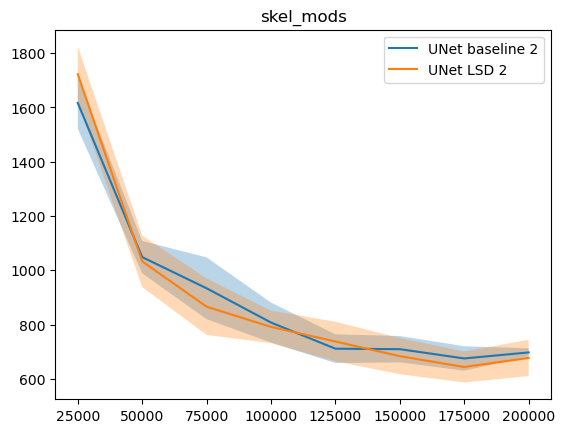

In [63]:
compare_models([["UNet baseline run 1", "UNet baseline run 2", "UNet baseline run 3", "UNet baseline 2"], ["UNet LSD 2 run 1", "UNet LSD 2 run 2", "UNet LSD 2 run 3", "UNet LSD 2"]], "skel_mods")

In [46]:
get_metrics_for_model("UNet LSD GELU LayerNorm")["skel_mods"]

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-100000/result.json']


array([1427, 1027,  923,  757,  602,  749,  627,  528])

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-100000/result.json']
['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-200000/result.json', '/

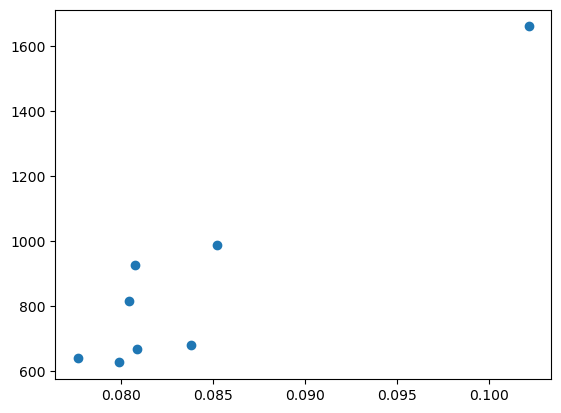

In [39]:
edits = get_metrics_for_model("UNet baseline 2")["skel_mods"]
its = get_metrics_for_model("UNet baseline 2")["checkpoints"]
loss = d[its]
#plt.plot(loss, edits)

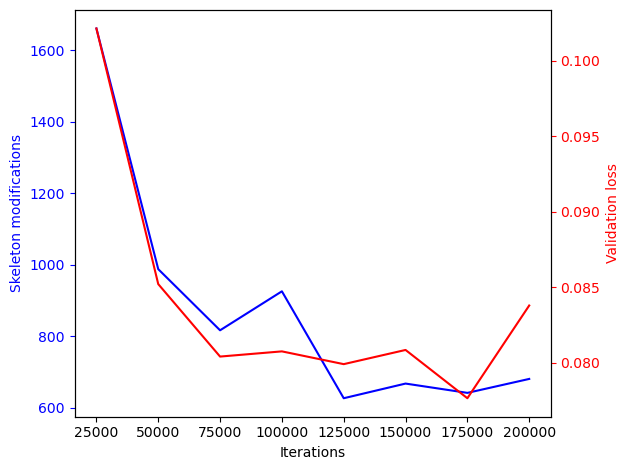

In [45]:
fig, ax1 = plt.subplots()
ax1.plot(its, edits, 'b-')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Skeleton modifications', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(its, loss, 'r-')
ax2.set_ylabel('Validation loss', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()

In [39]:
#model_name = "UNet LSD 2"
model_name = "UNet baseline 2"

In [40]:
path = f"/home/anton/github/autoseg/src/autoseg/artifacts/{model_name.replace(' ', '_')}/results"
files = glob.glob(path + "/step-*/result.json")
files

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-75000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-200000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-125000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-0/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-150000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-25000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-175000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-50000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-100000/result.json']

In [41]:
merges = []
splits = []
checkpoints = []
for f in sorted(files, key=lambda x: int(x.split("/")[-2].split("-")[1])):
  checkpoints.append(f.split("/")[-2].split("-")[1])
  results = json.load(open(f))
  merges.append(results["best_edits"]["total_merges_needed_to_fix_splits"])
  splits.append(results["best_edits"]["total_splits_needed_to_fix_merges"])
  print(f)


/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-0/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-25000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-50000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-75000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-100000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-125000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-150000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-175000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-200000/result.json


In [37]:
(np.array(merges) + np.array(splits))[1:].min()

690

In [42]:
baseline = np.array(merges) + np.array(splits)

In [38]:
lsd = np.array(merges) + np.array(splits)

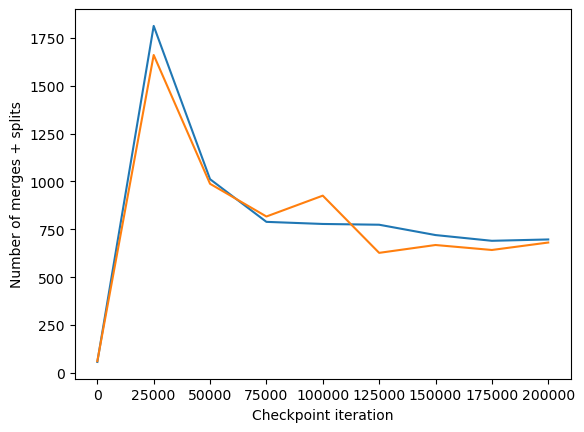

In [43]:
plt.ylabel("Number of merges + splits")
plt.xlabel("Checkpoint iteration")
#plt.title(model_name)
plt.plot(checkpoints, lsd, label="LSD baseline")
plt.plot(checkpoints, baseline, label="Pure Aff baseline")

In [22]:
def plot_metric(metric):
  vals = []
  checkpoints = []
  for f in sorted(files, key=lambda x: int(x.split("/")[-2].split("-")[1])):
    checkpoints.append(f.split("/")[-2].split("-")[1])
    results = json.load(open(f))
    vals.append(results["best_nvi"][metric])
  plt.ylabel(metric)
  plt.xlabel("Checkpoint iteration")
  plt.plot(checkpoints, vals)
  

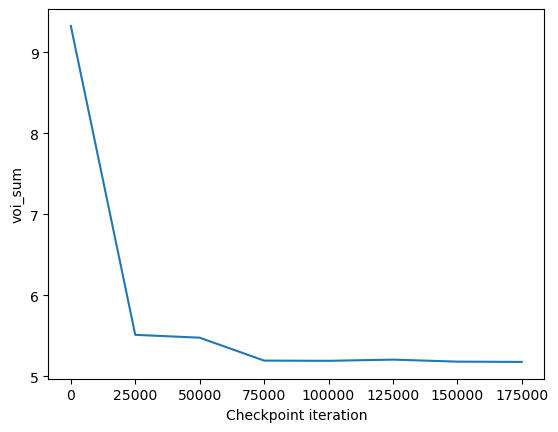

In [25]:
plot_metric("voi_sum")